# Empirical A_V Fitter for XShooter Data
## KWD, mid-2019
### MSP Version, 8 November 2019

Goals for the notebook:
1. Estimate Spectral Type and veiling
2. Perform grid comparison with stellar templates of different SpT, veiling, and extinction
3. Infer physical properties: Teff, Lstar, Rstar, Mstar, using tabulated conversions.

Mini steps:
1. Interpolated to save wavelength axis: use rebinspec in spec_modelfit
2. Give reasonable range of Av

#### MSP Notes

1. Install dust_extinction:

  conda config --add channels conda-forge
  
  conda install dust_extinction

In [64]:
# standard imports
import numpy as np
import time
import glob

# astropy imports
from astropy.table import Table
from astropy.io import fits
from astropy import units as u
from astropy import constants as const
from astropy.stats import SigmaClip

# dust extinction (may need special import)
from dust_extinction.parameter_averages import F99

# custom software
from spec_modelfit import *

# ipython reload capabilities for edits to external code
%load_ext autoreload
%autoreload 2

# plotting helpers
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Spectral Typing in the Visible

In [260]:
# newest xshooter spectrum instead
# data = np.loadtxt('../RV/xshooter_oct_medvis.txt', skiprows=1) # optical Oct data
data = np.loadtxt('../RV/xshooter_dec_medvis.txt', skiprows=1) # optical Dec data
# data = np.loadtxt('../RV/xshooter_mednir_dec.txt', skiprows=1) # NIR Dec data


wavelength_object = np.nan_to_num(data[:, 0])/1000.
flux_object = np.nan_to_num(data[:, 1])
uncertainty_object = np.nan_to_num(data[:, 2])

# clean up the values where the uncertainty is zero:
wavelength_object = wavelength_object[uncertainty_object != 0]
flux_object = flux_object[uncertainty_object != 0]
uncertainty_object = uncertainty_object[uncertainty_object != 0]

# set the wavelength bounds
flux_object = flux_object[(wavelength_object > .57) & (wavelength_object < 1.01)]
uncertainty_object = uncertainty_object[(wavelength_object > .57) & (wavelength_object < 1.01)]
wavelength_object = wavelength_object[(wavelength_object > .57) & (wavelength_object < 1.01)]


# convert to a dictionary. as long as this step happens for any other data, we will be able to 
V410 = {}
V410['wave'] = wavelength_object
V410['flux'] = flux_object
V410['eflux'] = uncertainty_object




## Load in Manara+ spectra, but from their own reductions (VizieR)

This data has been pulled directly from the Manara paper. Unfortunately, there are no errors.

In [262]:
# read all of the visible arm spectra into a dictionary:
manara_spec = {}
V_templates = glob.glob('../Extinction/Manara2013_Library/ManaraReductions/*_V.txt')

print(V_templates)

['../Extinction/Manara2013_Library/ManaraReductions/01_Sz121_M4.0_V.txt', '../Extinction/Manara2013_Library/ManaraReductions/02_Sz94_M4.0_V.txt', '../Extinction/Manara2013_Library/ManaraReductions/03_SO797_M4.5_V.txt', '../Extinction/Manara2013_Library/ManaraReductions/04_SO641_M5.0_V.txt', '../Extinction/Manara2013_Library/ManaraReductions/05_Par-Lup3-2_M5.0_V.txt', '../Extinction/Manara2013_Library/ManaraReductions/06_SO925_M5.5_V.txt', '../Extinction/Manara2013_Library/ManaraReductions/07_SO999_M5.5_V.txt', '../Extinction/Manara2013_Library/ManaraReductions/08_Sz107_M5.5_V.txt', '../Extinction/Manara2013_Library/ManaraReductions/09_Par-Lup3-1_M6.5_V.txt']


In [263]:


# read in all templates

# when bringing in, should bring to the native resolution of the data?
# rebin spec takes a minute or two (what version of this do I have?)

for templ in V_templates:
    print(templ)
    wvtmp, fltmp = np.genfromtxt(templ, skip_header=1, unpack=True)
    
    wvtmp/=1000.
    print(np.nanmin(V410['wave']),np.nanmin(wvtmp))
    print(np.nanmax(V410['wave']),np.nanmax(wvtmp))


    # do the rebin.
    
    rebin_flux = rebinspec(wvtmp, fltmp, V410['wave'])
    #rebin_flux = spectres(V410['wave'], wvtmp,fltmp, spec_errs=None)
    
    fl = rebin_flux*(u.mW)*(u.m**-2)*(u.nm**-1)
    conv_fl = fl.to((u.erg)*(u.s**-1)*(u.cm**-2)*(u.angstrom**-1))
    manara_spec[templ] = {}
    manara_spec[templ]['wave'] = V410['wave']
    manara_spec[templ]['flux'] = conv_fl.value


../Extinction/Manara2013_Library/ManaraReductions/01_Sz121_M4.0_V.txt
0.5700042294469999 0.53366
1.00999205611 1.01998
../Extinction/Manara2013_Library/ManaraReductions/02_Sz94_M4.0_V.txt
0.5700042294469999 0.545
1.00999205611 1.035
../Extinction/Manara2013_Library/ManaraReductions/03_SO797_M4.5_V.txt
0.5700042294469999 0.54599
1.00999205611 1.03001
../Extinction/Manara2013_Library/ManaraReductions/04_SO641_M5.0_V.txt
0.5700042294469999 0.546
1.00999205611 1.03
../Extinction/Manara2013_Library/ManaraReductions/05_Par-Lup3-2_M5.0_V.txt
0.5700042294469999 0.545
1.00999205611 1.035
../Extinction/Manara2013_Library/ManaraReductions/06_SO925_M5.5_V.txt
0.5700042294469999 0.546
1.00999205611 1.03
../Extinction/Manara2013_Library/ManaraReductions/07_SO999_M5.5_V.txt
0.5700042294469999 0.54599
1.00999205611 1.01899
../Extinction/Manara2013_Library/ManaraReductions/08_Sz107_M5.5_V.txt
0.5700042294469999 0.546
1.00999205611 1.019
../Extinction/Manara2013_Library/ManaraReductions/09_Par-Lup3-1_M6

## An experiment to try spectral typing one of the known members against each other 

In [278]:
# a bunch of definitions to do the comparison...

def spec_difference(spec1,spec2,sclval=1.):
    """for spectra with the same wavelength, compute the total difference
    
    inputs
    ---------
    spec1      : first spectra, with 'wave' and 'flux' defined
    spec2      : second spectra, assumed to have same wavelengths as spec1
    sclval     : scaling value to apply to spec2 before computing the difference
    
    returns
    ---------
    difference quantity: fractional deviation
    
    
    todo
    ---------
    what to do with error handling?
    
    
    """
    if spec1['wave'][0] != spec2['wave'][0]:
        print('compare_spectra: wavelengths are not the same.')
        
    return np.sum(np.abs((spec1['flux'] - sclval*spec2['flux'])/spec1['flux']))

    

def minimize_offset(spec1,spec2,iterate=False):
    """compute a minimum residual offset value
    
    inputs
    ---------
    spec1      : first spectra, with 'wave' and 'flux' defined
    spec2      : second spectra, assumed to have same wavelengths as spec1
    
    
    returns
    ---------
    best-fit scale value for spec2 to minimize difference with spec1
    
    
    dependencies
    ---------
    spec_difference 
    
    
    """
    scalevals = np.linspace(-5.,5.,1000)
    residual = np.zeros(scalevals.size)

    for isclval,sclval in enumerate(scalevals):
        residual[isclval] = spec_difference(spec1,spec2,sclval=10.**sclval)
        
    # do it again for certainty?
    if iterate:
        scalevals = np.linspace(scalevals[residual.argmin()]-1.,scalevals[residual.argmin()]+1.,1000)
        residual = np.zeros(scalevals.size)

        for isclval,sclval in enumerate(scalevals):
            residual[isclval] = spec_difference(spec1,spec2,sclval=10.**sclval)
    
    return 10.**scalevals[residual.argmin()]
    



def compare_spectra(spec1,spec2,plotting=True,scale=True,title='',av=-1.):
    '''compare two spectra with one another

    inputs
    ---------
    spec1      : first spectra, with 'wave' and 'flux' defined
    spec2      : second spectra, assumed to have same wavelengths as spec1
    plotting   : boolean, True creates a diagnostic plot
    scale      : boolean, True if spec2 should be scaled to spec1
    title      : title for plot (if made)
    av         : extinction to apply to spec1
    
    
    returns
    ---------
    offset : best fit scaling value to make spec2 match spec1
    
    dependencies
    ---------
    minimize_offset
    spec_difference
    
    todo
    ---------
    
    '''
    # what cleaning is necessary to compare?
    
    if spec1['wave'][0] != spec2['wave'][0]:
        print('compare_spectra: wavelengths are not the same.')
        
    compspec = {}
    compspec['wave'] = spec1['wave']
        
    # apply extinction if desired
    if av>0.:
        ext = F99(Rv=3.1) # 3.1
        compspec['flux'] = spec1['flux']*ext.extinguish(compspec['wave']*u.um, Av=av)
        
    else:
        compspec['flux'] = spec1['flux']
        
        
    # if scale is True, try to minimize the residuals with an overall fit to the amplitude
    if scale:
        # find the scaling for spec2 which minimizes the difference with compspec (extincted spec1)
        offset = minimize_offset(compspec,spec2,iterate=True)
    else:
        offset = 1.
        
    total_residual = np.sum(np.abs(compspec['flux']-offset*spec2['flux'])/compspec['flux'])
    total_residual /= spec2['flux'].size


    if plotting:
        fig = plt.figure(figsize=(10,3))
        ax1 = fig.add_axes([0.2,0.5,0.7,0.47])
        ax2 = fig.add_axes([0.2,0.22,0.7,0.2])


        ax1.plot(compspec['wave'],compspec['flux'],color='black')
        ax1.plot(spec2['wave'],offset*spec2['flux'],color='red')

        ax2.plot(compspec['wave'],(compspec['flux']-offset*spec2['flux'])/compspec['flux'],color='black')
        ax2.plot([np.nanmin(spec1['wave']),np.nanmax(spec1['wave'])],[0.,0.],color='gray',lw=1.,linestyle='dashed')

        ax2.text(np.nanmax(spec1['wave']),0.,'e={}\nA={}\nAv={}'.format(np.round(total_residual,2),np.round(offset,3),np.round(av,2)),color='black',ha='left')

        ax1.set_xlim([np.nanmin(spec1['wave']),np.nanmax(spec1['wave'])])
        ax2.axis([np.nanmin(spec1['wave']),np.nanmax(spec1['wave']),-1.,1.])
        ax1.set_title(title,size=12)
        ax2.set_xlabel('Wavelength ($\mu$m)',size=12)
        ax2.set_ylabel('Residuals',size=12)
        ax1.set_ylabel('Flux',size=12)
        ax1.set_xticklabels(())

    return offset

    

def compare_spectra_extinction(spec1,spec2,plotting=True,scale=True,title='',extmax=2.,extnum=10):
    '''compare two spectra with one another, testing extinction range
    
    inputs
    ---------
    spec1      : first spectra, with 'wave' and 'flux' defined
    spec2      : second spectra, assumed to have same wavelengths as spec1
    plotting   : boolean, True creates a diagnostic plot
    scale      : boolean, True if spec2 should be scaled to spec1
    extmax     : maximum extinction value to test
    extnum     : number of extinction values to test
    
    
    returns
    ---------
    offset : best fit scaling value to make spec2 match spec1
    
    dependencies
    ---------
    minimize_offset
    spec_difference
    
    todo
    ---------    
    
    '''
    # what cleaning is necessary to compare?
    
    if spec1['wave'][0] != spec2['wave'][0]:
        print('compare_spectra: wavelengths are not the same.')
        
    # set up to apply extinction
    compspec = {}
    compspec['wave'] = spec1['wave']
    ext = F99(Rv=3.1) # 3.1
        
    
    extrange = np.linspace(0.,extmax,extnum)
    total_residual = np.zeros(extrange.size)

    fig = plt.figure(figsize=(10,3))
    ax1 = fig.add_axes([0.2,0.5,0.7,0.47])
    ax2 = fig.add_axes([0.2,0.22,0.7,0.2])


    for iav,av in enumerate(extrange):
        compspec['flux'] = spec1['flux']*ext.extinguish(compspec['wave']*u.um, Av=av)
        offset = minimize_offset(spec2,compspec,iterate=True)
        
        # I feel that this needs some scaling to account for the uncertainty in the comparison flux...
        total_residual[iav] = np.sum(np.abs(spec2['flux']-offset*compspec['flux'])/spec2['flux'])/spec2['flux'].size
    
        if iav==0:
            ax1.plot(spec2['wave'],offset*compspec['flux'],color='darkgray',lw=1.5) # with no extinction   
        else:
            ax1.plot(spec2['wave'],offset*compspec['flux'],color='gray',alpha=0.5,lw=1.5)
            

        if iav==0:
            ax2.plot(spec2['wave'],(spec2['flux']-offset*compspec['flux'])/spec2['flux'],color='darkgray',lw=1.5)
        else:
            ax2.plot(spec2['wave'],(spec2['flux']-offset*compspec['flux'])/spec2['flux'],color='gray',alpha=0.5,lw=1.5)
        
        ax2.plot([np.nanmin(spec1['wave']),np.nanmax(spec1['wave'])],[0.,0.],color='gray',lw=1.,linestyle='dashed')

    ax1.plot(spec1['wave'],spec2['flux'],color='red',lw=1.5)


    # plot the best residual
    best_residual = np.argmin(total_residual)
    compspec['flux'] = spec1['flux']*ext.extinguish(compspec['wave']*u.um, Av=extrange[best_residual])
    offset = minimize_offset(spec2,compspec,iterate=True)
    ax1.plot(compspec['wave'],offset*compspec['flux'],color='black',lw=1.5)
    ax2.plot(compspec['wave'],(spec2['flux']-offset*compspec['flux'])/spec2['flux'],color='black',lw=1.5)
    ax2.text(np.nanmax(spec1['wave']),0.,'e={}\nA={}\nAv={}'.format(np.round(np.nanmin(total_residual),2),np.round(offset,3),np.round(extrange[best_residual],2)),color='black',ha='left')
        
    ax1.set_xlim([np.nanmin(spec1['wave']),np.nanmax(spec1['wave'])])
    ax2.axis([np.nanmin(spec1['wave']),np.nanmax(spec1['wave']),-1.,1.])
    ax1.set_title(title,size=12)
    ax2.set_xlabel('Wavelength ($\mu$m)',size=12)
    ax2.set_ylabel('Residuals',size=12)
    ax1.set_ylabel('Flux',size=12)
    ax1.set_xticklabels(())


    


../Extinction/Manara2013_Library/ManaraReductions/01_Sz121_M4.0_V.txt 1.1221477682079801
../Extinction/Manara2013_Library/ManaraReductions/02_Sz94_M4.0_V.txt 0.4442706749606885
../Extinction/Manara2013_Library/ManaraReductions/03_SO797_M4.5_V.txt 0.03877828414589457
../Extinction/Manara2013_Library/ManaraReductions/04_SO641_M5.0_V.txt 0.020151357338155585
../Extinction/Manara2013_Library/ManaraReductions/05_Par-Lup3-2_M5.0_V.txt 0.3544455673970436
../Extinction/Manara2013_Library/ManaraReductions/06_SO925_M5.5_V.txt 0.018979216428391014
../Extinction/Manara2013_Library/ManaraReductions/07_SO999_M5.5_V.txt 0.0435149650092505
../Extinction/Manara2013_Library/ManaraReductions/08_Sz107_M5.5_V.txt 0.2920555512182748
../Extinction/Manara2013_Library/ManaraReductions/09_Par-Lup3-1_M6.5_V.txt 0.013744790926775366


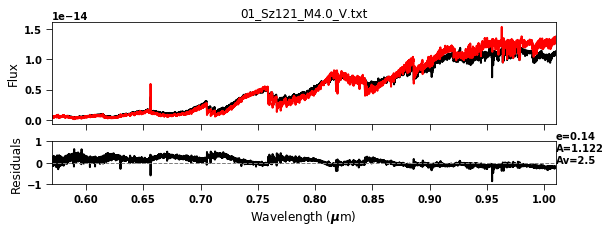

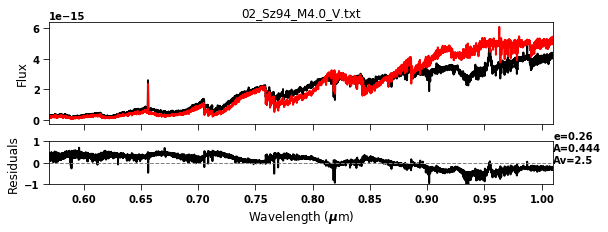

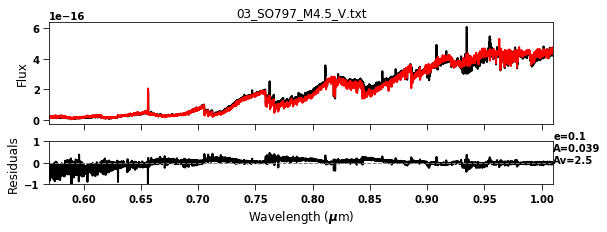

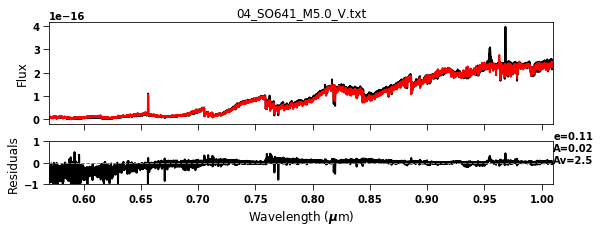

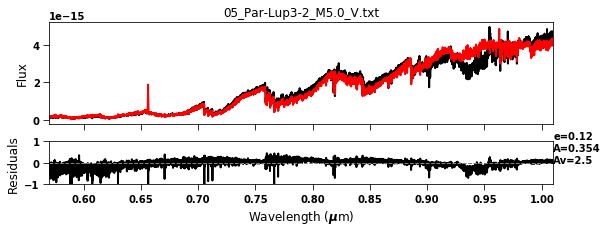

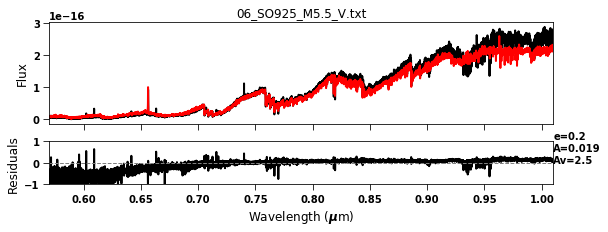

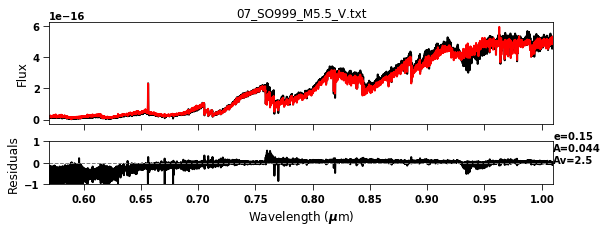

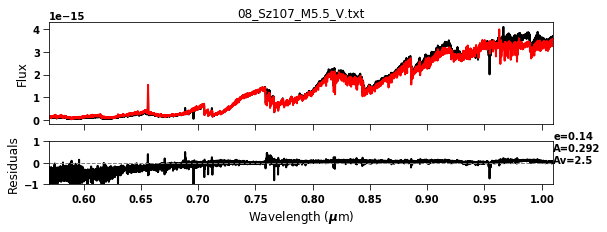

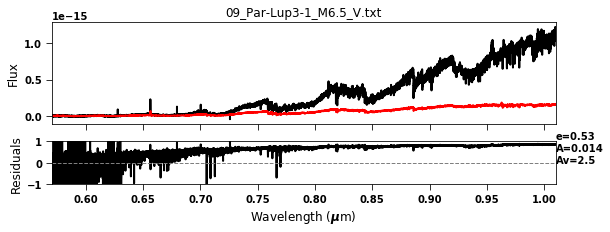

In [279]:



for idx,templ in enumerate(V_templates):
    offset = compare_spectra(manara_spec[templ],V410,plotting=True,title=templ.split('/')[-1],av=2.5)
    print(templ,offset)


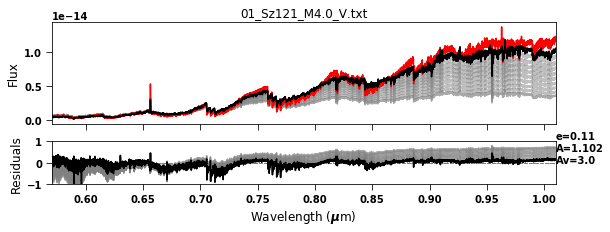

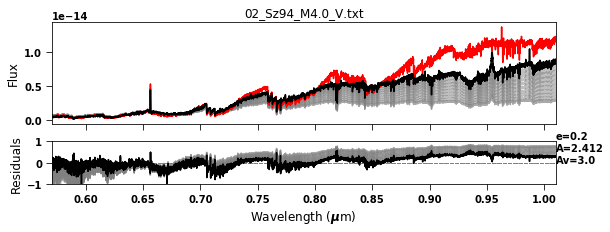

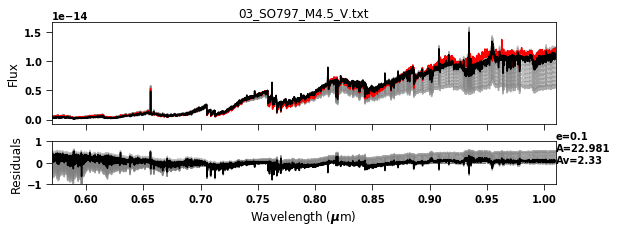

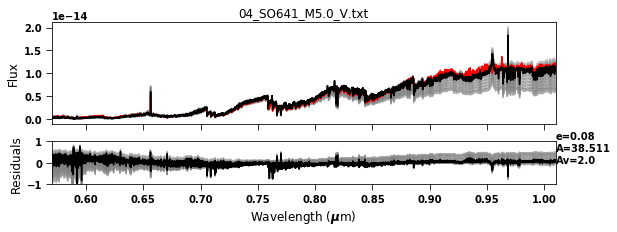

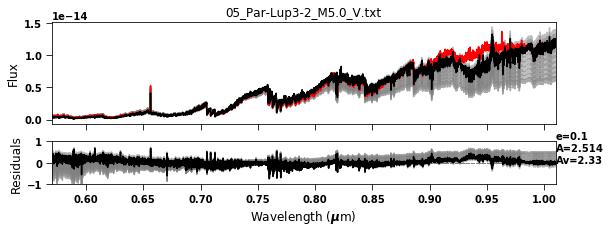

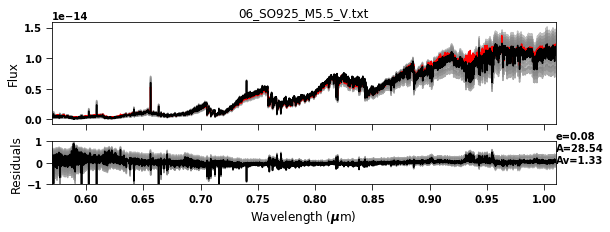

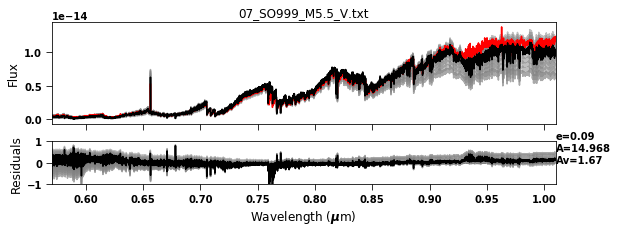

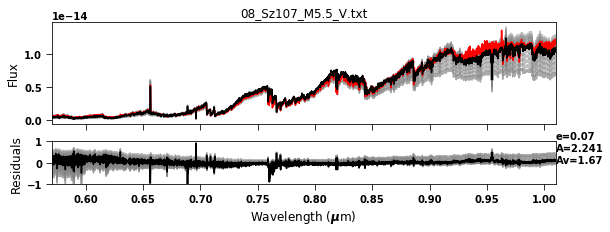

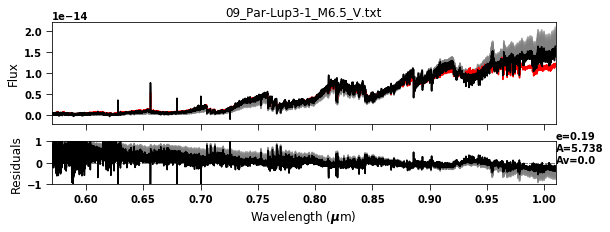

In [280]:

for idx,templ in enumerate(V_templates):
    compare_spectra_extinction(manara_spec[templ],V410,plotting=True,title=templ.split('/')[-1],extmax=3.,extnum=10)


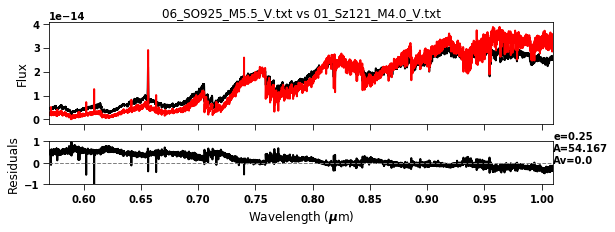

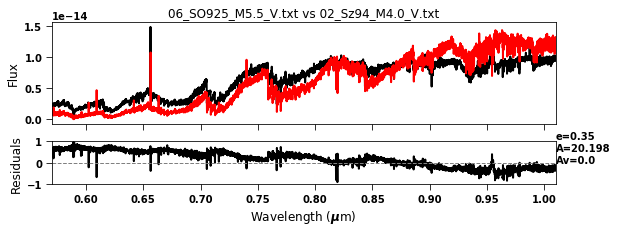

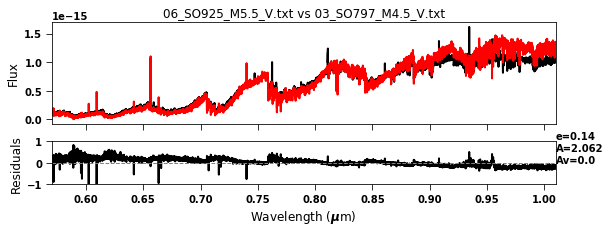

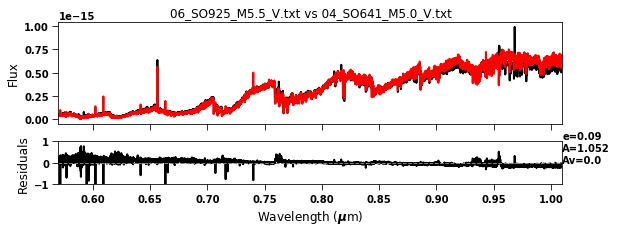

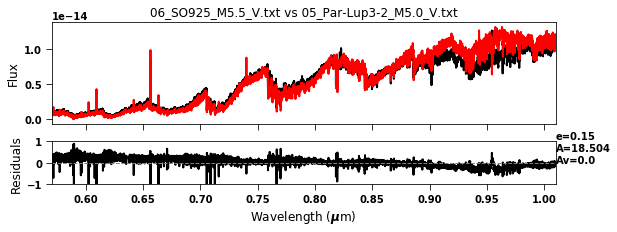

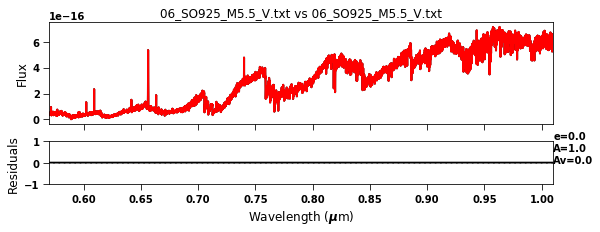

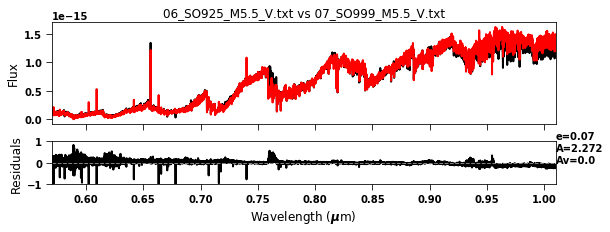

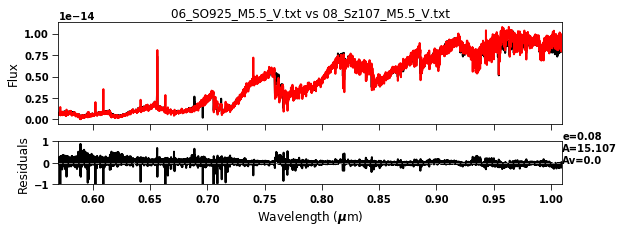

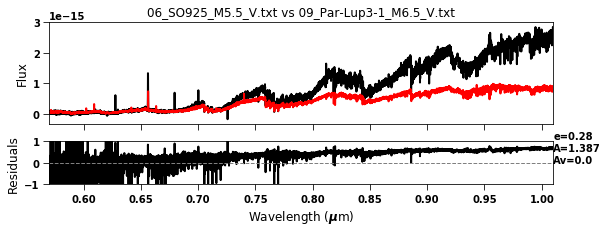

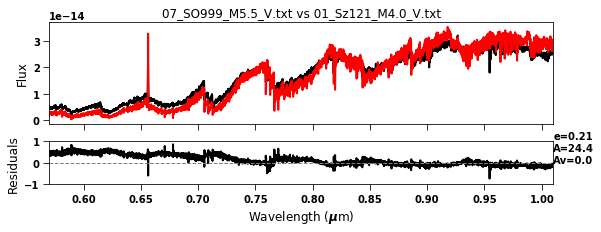

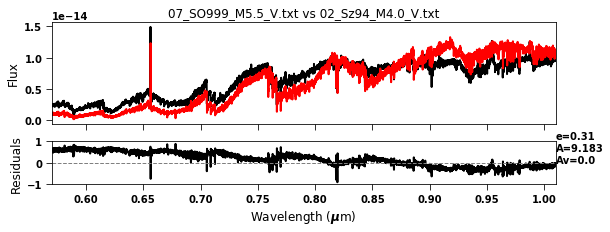

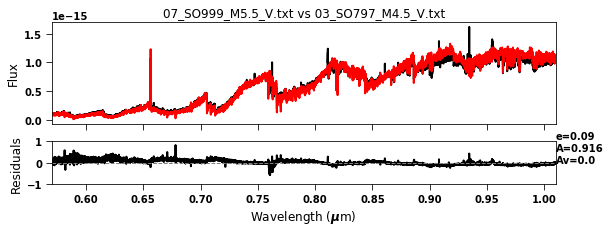

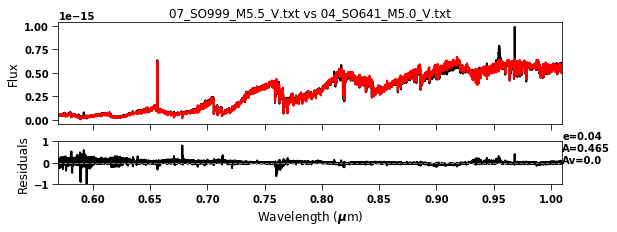

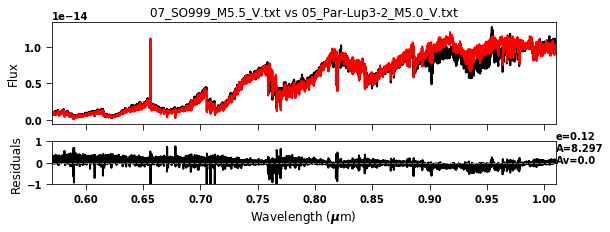

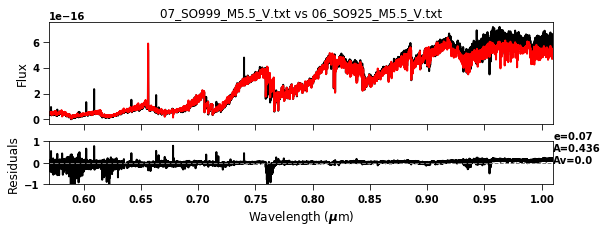

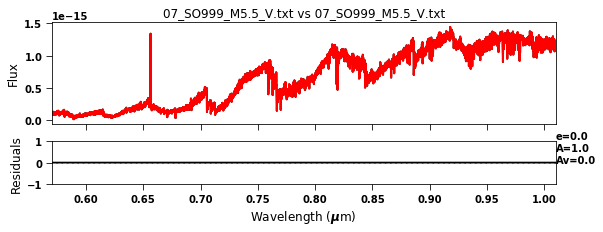

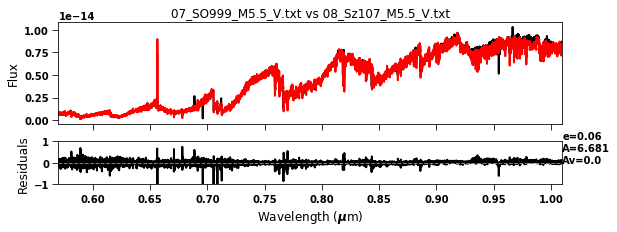

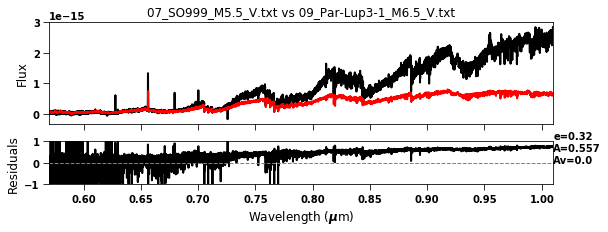

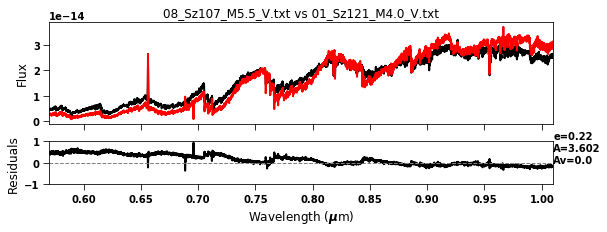

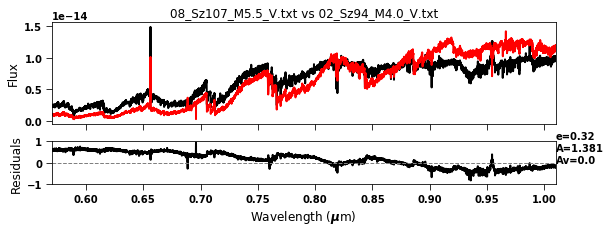

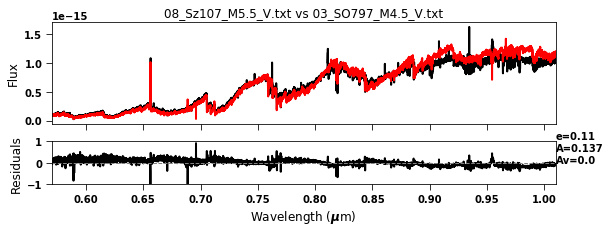

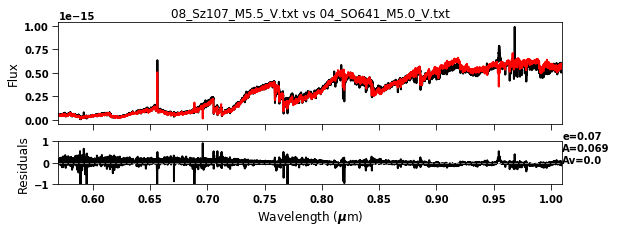

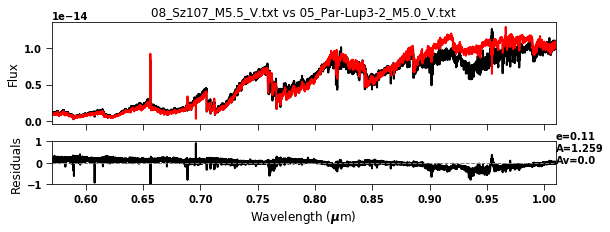

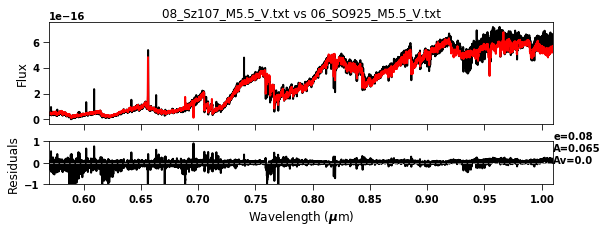

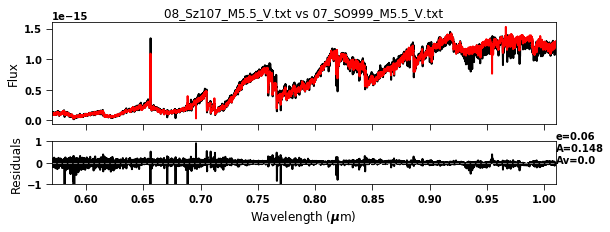

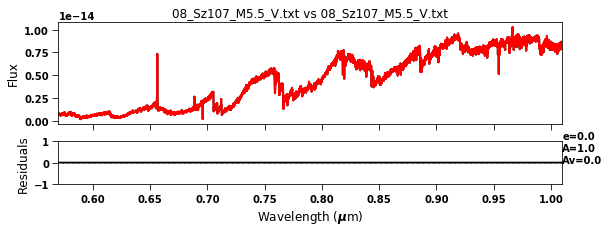

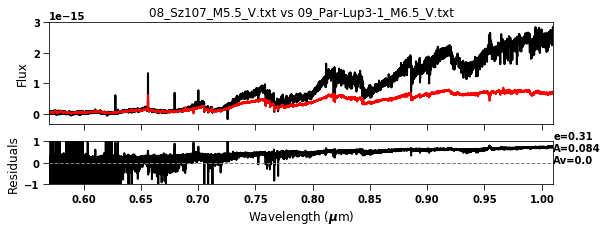

In [281]:
# check the 5.5s against everything else

for idx_in,templ_in in enumerate(V_templates):
    if '5.5' in templ_in:
        for idx,templ in enumerate(V_templates):
            offset = compare_spectra(manara_spec[templ],manara_spec[templ_in],plotting=True,title=templ_in.split('/')[-1]+' vs '+templ.split('/')[-1],av=0.)



## Now try scaling for distance:

In [52]:
# V410 distance:
d_v410 = 1000/8.3771

# sz107 distance
d_sz107 = 1000/6.5635
scale_factor = (d_sz107/d_v410)**2
scale_factor

1.6289825061877268